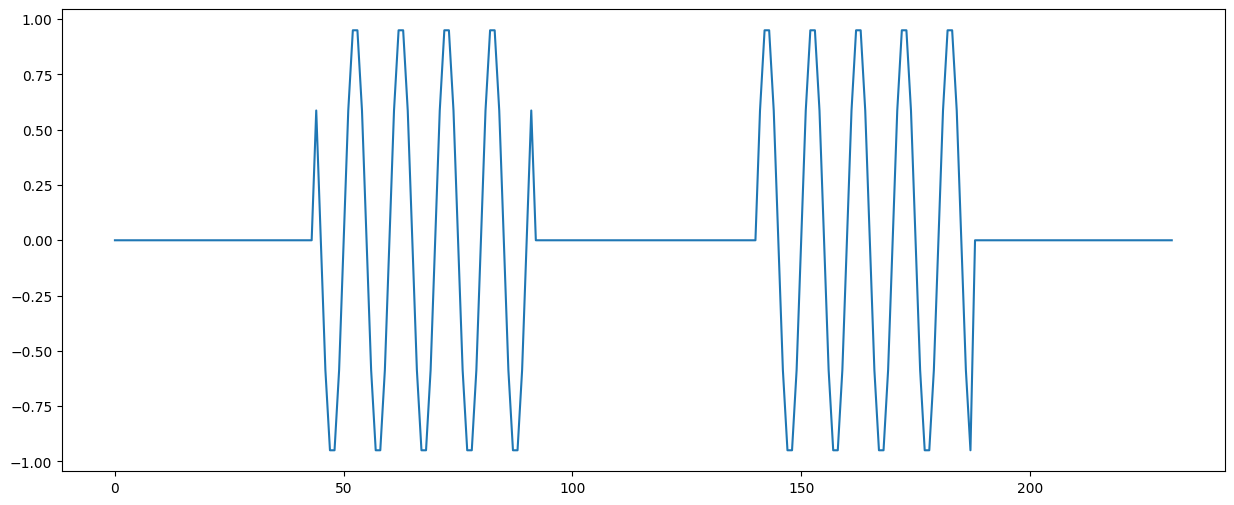

In [2]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

plot(generate_morse_signal("i", 100, 10, 40, 400, 0.11) )

In [1]:
import numpy as np

# see also generator: file://wsl.localhost/Ubuntu/home/jluu/hobby_l/morse_decoder_nn/generateur.html
def generate_morse_signal(
    text: str = "CQ CQ de F1FGV",
    snr_db: float = 0.0,
    wpm: float = 10.0,
    carrier_freq: float = 900.0,
    fs: int = 11025,
    duration_pad: float = 0.5
) -> np.ndarray:
    """
    Génère un signal Morse modulé en amplitude avec bruit gaussien.
    
    Args:
        text (str): Message à coder en Morse (ex: "CQ CQ DE F4XXX")
        snr_db (float): SNR en dB (peut être négatif, ex: -18)
        wpm (float): Vitesse en mots par minute (5 à 50)
        fs (int): Fréquence d'échantillonnage (11025 Hz)
        duration_pad (float): Silence (s) ajouté avant/après le message
    
    Returns:
        np.ndarray: Signal audio (float32, -1 à 1)
    """
    # === 1. Dictionnaire Morse (ITU standard) ===
    MORSE_CODE = {
        'A': '.-',    'B': '-...',  'C': '-.-.', 'D': '-..',  'E': '.',
        'F': '..-.',  'G': '--.',   'H': '....', 'I': '..',   'J': '.---',
        'K': '-.-',   'L': '.-..',  'M': '--',   'N': '-.',   'O': '---',
        'P': '.--.',  'Q': '--.-',  'R': '.-.',  'S': '...',  'T': '-',
        'U': '..-',   'V': '...-',  'W': '.--',  'X': '-..-', 'Y': '-.--',
        'Z': '--..',  '0': '-----', '1': '.----', '2': '..---', '3': '...--',
        '4': '....-', '5': '.....', '6': '-....', '7': '--...', '8': '---..',
        '9': '----.', '.': '.-.-.-', ',': '--..--', '?': '..--..', '/': '-..-.',
        '=': '-...-', '+': '.-.-.', ':': '---...', "'": '.----.', '-': '-....-',
        '(': '-.--.', ')': '-.--.-', '@': '.--.-.'
    }

    # === 2. Calcul des durées (ITU standard) ===
    # 1 mot = "PARIS " → 50 unités de temps
    unit_time = 1.2 / wpm  # secondes par point
    dit = unit_time
    dah = 3 * unit_time
    symbol_space = unit_time          # entre dit/dah dans une lettre
    letter_space = 3 * unit_time      # entre lettres
    word_space = 7 * unit_time        # entre mots

    # === 3. Construction du signal temporel (modulation OOK) ===
    t_total = 0.0
    # Padding silence before
    pad_samples = int(duration_pad * fs)
    modulation = np.array([], dtype=np.float32)
    silence = np.zeros(pad_samples, dtype=np.float32)
    modulation = np.concatenate([modulation, silence])

    words = text.upper().split()
    for i, word in enumerate(words):
        for j, char in enumerate(word):
            if char == ' ':
                continue
            if char not in MORSE_CODE:
                continue  # ignore inconnu

            code = MORSE_CODE[char]
            for k, symbol in enumerate(code):
                if symbol == '.':
                    duration = dit
                elif symbol == '-':
                    duration = dah

                # Ajout du symbole
                t_symbol = np.linspace(t_total, t_total + duration, int(duration * fs), endpoint=False)
                modulation = np.concatenate([modulation, np.ones(len(t_symbol), dtype=np.float32)])
                t_total += duration

                # Espace entre symboles (sauf dernier)
                if k < len(code) - 1:
                    t_total += symbol_space
                    modulation = np.concatenate([modulation, np.zeros(int(symbol_space * fs))])

            # Espace entre lettres (sauf dernière du mot)
            if j < len(word) - 1:
                t_total += letter_space
                modulation = np.concatenate([modulation, np.zeros(int(letter_space * fs))])

        # Espace entre mots (sauf dernier)
        if i < len(words) - 1:
            t_total += word_space
            modulation = np.concatenate([modulation, np.zeros(int(word_space * fs))])

    # Padding silence after
    modulation = np.concatenate([modulation, silence])
        
    # === 4. Génération du signal sinusoïdal modulé ===
    t = np.arange(len(modulation)) / fs
    signal_clean = modulation * np.sin(2 * np.pi * carrier_freq * t)

    # === 5. Ajout du bruit selon SNR ===
    signal_power = np.mean(signal_clean**2)
    if signal_power == 0:
        return np.zeros(int((duration_pad * 2 + 1) * fs), dtype=np.float32)

    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(signal_clean))

    signal_noisy = signal_clean + noise

    # === 6. Normalisation et padding ===
    if np.max(np.abs(signal_noisy)) > 0:
        signal_noisy = signal_noisy / np.max(np.abs(signal_noisy)) * 0.95  # -0.4 dB peak

    return signal_noisy.astype(np.float32)

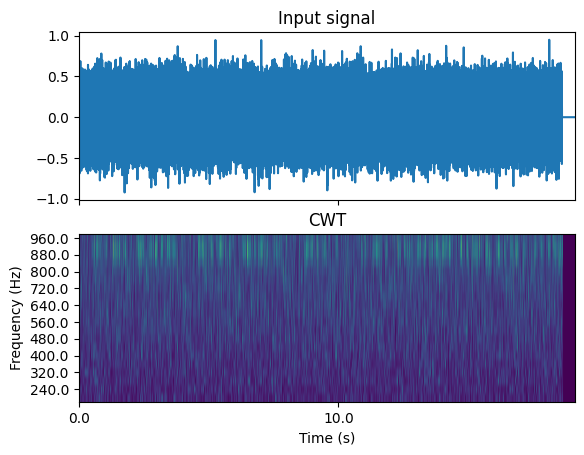

In [2]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt
snr_db = -18

# Signal
fs = 11025
morse_signal = generate_morse_signal(snr_db=snr_db)   # shape (N,)
f0 = 200 #lowest frequency
f1 = 1000 #highest frequency
fn = 20 #number of frequencies

#plot cwt
fcwt.plot(morse_signal, fs, f0=f0, f1=f1, fn=fn)

In [6]:
snr_db=-10
morse_signal=generate_morse_signal("i", snr_db)

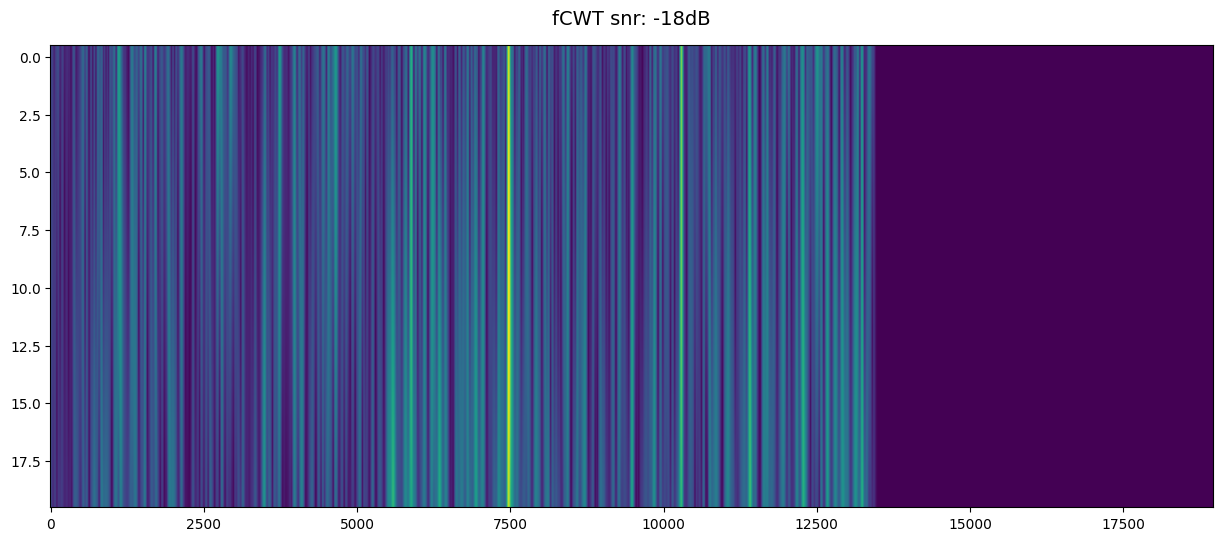

In [46]:
#initialize Morlet wavelet with wavelet parameter (sigma) 2.0
morl = fcwt.Morlet(2.0)

#initialize scales
scales = fcwt.Scales(morl, fcwt.FCWT_LINFREQS, fs, f0, f1, fn)

#initialize fcwt
nthreads = 8
use_optimization_plan = False
use_normalization = True
fcwt_obj = fcwt.FCWT(morl, nthreads, use_optimization_plan, use_normalization)

#initialize output array
output = np.zeros((fn,morse_signal.size), dtype=np.complex64)

#calculate cwt
fcwt_obj.cwt(morse_signal, scales, output)

#plot cwt
# === 5. YTICKS automatiques ===
fmin = f0
fmax = f1
decades = np.arange(np.floor(np.log10(fmin)), np.ceil(np.log10(fmax)) + 1)
major_ticks = []
for d in decades:
    for factor in [1, 2, 5]:
        val = factor * 10**d
        if fmin <= val <= fmax:
            major_ticks.append(val)
major_ticks = np.unique(np.round(major_ticks, decimals=6))

if major_ticks.size == 0 or abs(major_ticks[0]/fmin - 1) > 0.3:
    major_ticks = np.concatenate([[fmin], major_ticks])
if abs(fmax/major_ticks[-1] - 1) > 0.3:
    major_ticks = np.concatenate([major_ticks, [fmax]])
major_ticks = np.unique(np.round(major_ticks, decimals=6))

# === 6. Plot ===
#plt.figure(figsize=figsize)

plt.yscale('linear')
#plt.ylim(fmin, fmax)
#plt.yticks(major_ticks,
#           [f"{x:.4f}".rstrip('0').rstrip('.') if x<1 else f"{int(x)}" for x in major_ticks])


#plot cwt
plt.imshow(np.abs(output),aspect='auto')
title = "fCWT snr: " + str(snr_db) + "dB"
plt.title(title, fontsize=14, pad=15)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT
from scipy.interpolate import griddata
from scipy.signal import lfilter, iirpeak

# Import rétro-compatible de hann
try:
    from scipy.signal import hann, hamming, flattop, blackman
except ImportError:
    # Fallback pour SciPy < 1.12 : utiliser scipy.signal.windows
    from scipy.signal.windows import hann, hamming, flattop, blackman
    print("Note: (SciPy < 1.12) importing windowing functions from scipy.signal.windows")

    
# Dictionnaire des fenêtres supportées (facile à étendre)
WINDOW_FUNCTIONS = {
    'hann': hann,
    'hamming': hamming,
    'flattop': flattop,
    'blackman': blackman,
    # Ajoute-en d'autres si besoin, ex: 'bartlett': bartlett, 'bohman': bohman, etc.
}

def plot_stft_like_fcwt(
    signal_to_process: np.ndarray,
    fs: float = 11025.0,
    fmin: float = 150.0,
    fmax: float = 1100.0,
    n_freqs_log: int = 400,
    hop: int | None = None,
    nperseg: int | None = None,
    overlap_factor: int = 2,
    window_function: str = "hann",
    title: str = "STFT (ShortTimeFFT) – équivalent fCWT",
    cmap: str = 'magma',
    vmin: float | None = None,
    vmax: float | None = None,
    figsize=(14, 6)
):
    """
    Scalogramme avec ShortTimeFFT – rétro-compatible SciPy 1.4+
    """
    fmin = max(fmin, 1e-6)   # Sécurité log

    # === 1. Manage arguments ===
    if nperseg is None:
        desired_bins = 40
        nperseg = int(fs * desired_bins / (fmax - fmin))
        nperseg = max(nperseg, 512)
        nperseg = 2 ** int(np.log2(nperseg) + 0.5)   # Puissance de 2
        print ("FFT width: " + str(nperseg))

    if hop is None:
        hop = nperseg // overlap_factor                           # 50% overlap

    if window_function not in WINDOW_FUNCTIONS:
        raise ValueError(f"Fenêtre non supportée : {window}. Choix possibles : {list(WINDOW_FUNCTIONS.keys())}")

    window_func = WINDOW_FUNCTIONS[window_function]
    window_name = window_function.upper() if window_function != 'flattop' else 'Flat Top'
    
    title = "ShortTimeFFT (%d, %d%% overlap) %s – %s" % (nperseg, 100 - 100//overlap_factor, window_name,title)
    
    
    window = window_func(nperseg, sym=False)  # Fonctionne maintenant !

    # === 2. ShortTimeFFT ===
    SFT = ShortTimeFFT(window, hop, fs, fft_mode='onesided')
    Zxx = SFT.stft(signal_to_process)          # shape (freqs, times)
    t = SFT.t(len(signal_to_process))          # Vecteur temps exact
    f = SFT.f                       # Vecteur fréquences (linéaire)

    for i in range(0,len(f)):
        if f[i] > 850 and f[i]<950:
            print (f"i:{i}, f:{f[i]}")
            
    #power_db = 20 * np.log10(np.abs(Zxx) + 1e-12)
    power_db = np.abs(Zxx ** 2)/600

    # === 3. Grille log-fréquence cible ===
    freqs_log = np.logspace(np.log10(fmin), np.log10(fmax), n_freqs_log)

    # === 4. Interpolation ===
    F_orig, T_orig = np.meshgrid(f, t, indexing='ij')
    points = np.column_stack((F_orig.ravel(), T_orig.ravel()))
    values = power_db.ravel()

    power_log = griddata(
        points, values,
        (freqs_log[:, None], t[None, :]),
        method='linear',
        fill_value=np.nan
    )
    power_log = np.nan_to_num(power_log, nan=np.nanmin(power_log))

    # === 5. YTICKS automatiques ===
    decades = np.arange(np.floor(np.log10(fmin)), np.ceil(np.log10(fmax)) + 1)
    major_ticks = []
    for d in decades:
        for factor in [1, 2, 5]:
            val = factor * 10**d
            if fmin <= val <= fmax:
                major_ticks.append(val)
    major_ticks = np.unique(np.round(major_ticks, decimals=6))

    if major_ticks.size == 0 or abs(major_ticks[0]/fmin - 1) > 0.3:
        major_ticks = np.concatenate([[fmin], major_ticks])
    if abs(fmax/major_ticks[-1] - 1) > 0.3:
        major_ticks = np.concatenate([major_ticks, [fmax]])
    major_ticks = np.unique(np.round(major_ticks, decimals=6))

    # === 6. Plot ===
    plt.figure(figsize=figsize)
    im = plt.pcolormesh(t, freqs_log, power_log,
                        shading='gouraud', cmap=cmap,
                        vmin=vmin if vmin is not None else power_log.min(),
                        vmax=vmax if vmax is not None else power_log.max())

    plt.yscale('log')
    plt.ylim(fmin, fmax)
    plt.yticks(major_ticks,
               [f"{x:.4f}".rstrip('0').rstrip('.') if x<1 else f"{int(x)}" for x in major_ticks])

    plt.xlabel('Temps (s)', fontsize=12)
    plt.ylabel('Fréquence (Hz)', fontsize=12)
    plt.title(title, fontsize=14, pad=15)
    plt.colorbar(im, label='Amplitude (mW)')
    plt.grid(True, which="both", ls=":", alpha=0.4, linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return f, t, power_db, power_log

Note: (SciPy < 1.12) importing windowing functions from scipy.signal.windows


i:316, f:850.5615234375
i:317, f:853.253173828125
i:318, f:855.94482421875
i:319, f:858.636474609375
i:320, f:861.328125
i:321, f:864.019775390625
i:322, f:866.71142578125
i:323, f:869.403076171875
i:324, f:872.0947265625
i:325, f:874.786376953125
i:326, f:877.47802734375
i:327, f:880.169677734375
i:328, f:882.861328125
i:329, f:885.552978515625
i:330, f:888.24462890625
i:331, f:890.936279296875
i:332, f:893.6279296875
i:333, f:896.319580078125
i:334, f:899.01123046875
i:335, f:901.702880859375
i:336, f:904.39453125
i:337, f:907.086181640625
i:338, f:909.77783203125
i:339, f:912.469482421875
i:340, f:915.1611328125
i:341, f:917.852783203125
i:342, f:920.54443359375
i:343, f:923.236083984375
i:344, f:925.927734375
i:345, f:928.619384765625
i:346, f:931.31103515625
i:347, f:934.002685546875
i:348, f:936.6943359375
i:349, f:939.385986328125
i:350, f:942.07763671875
i:351, f:944.769287109375
i:352, f:947.4609375


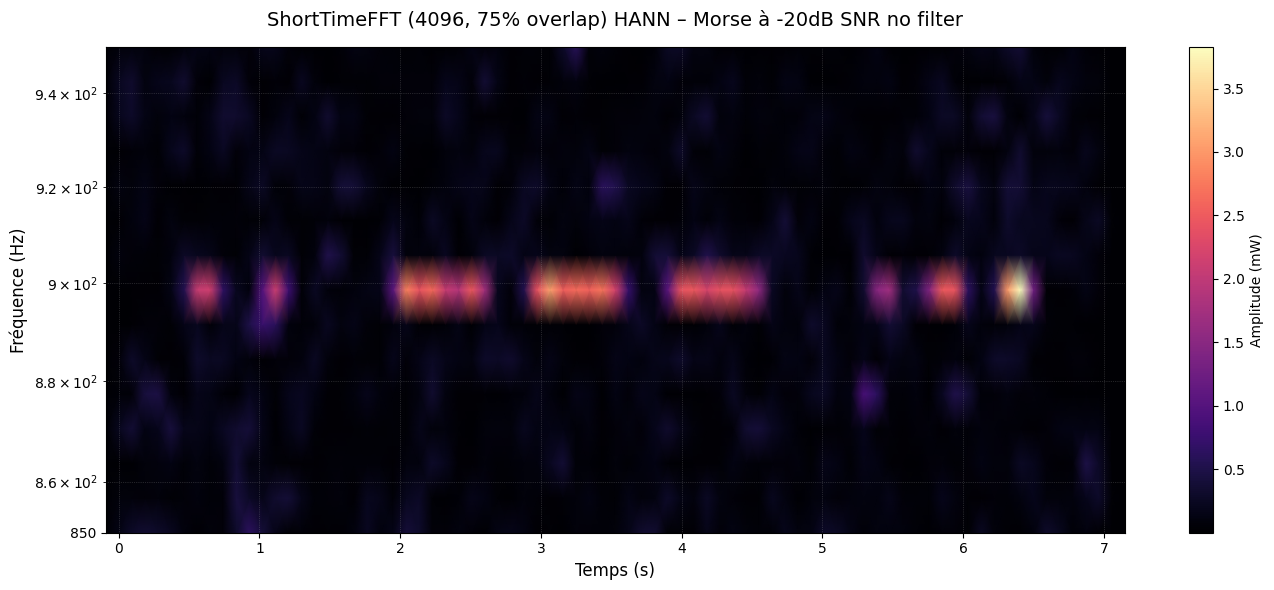

'done'

In [182]:
snr_db=-20
morse_signal = generate_morse_signal(text="ios", snr_db=snr_db , wpm=5)
plot_stft_like_fcwt(
    morse_signal,
    fs=fs,
    title="Morse à " + str(snr_db) + "dB SNR no filter",
    n_freqs_log = 15,
    fmin=850,
    fmax=950,
    window_function = 'hann',
    nperseg = 4096,
    overlap_factor =  4
)
'done'

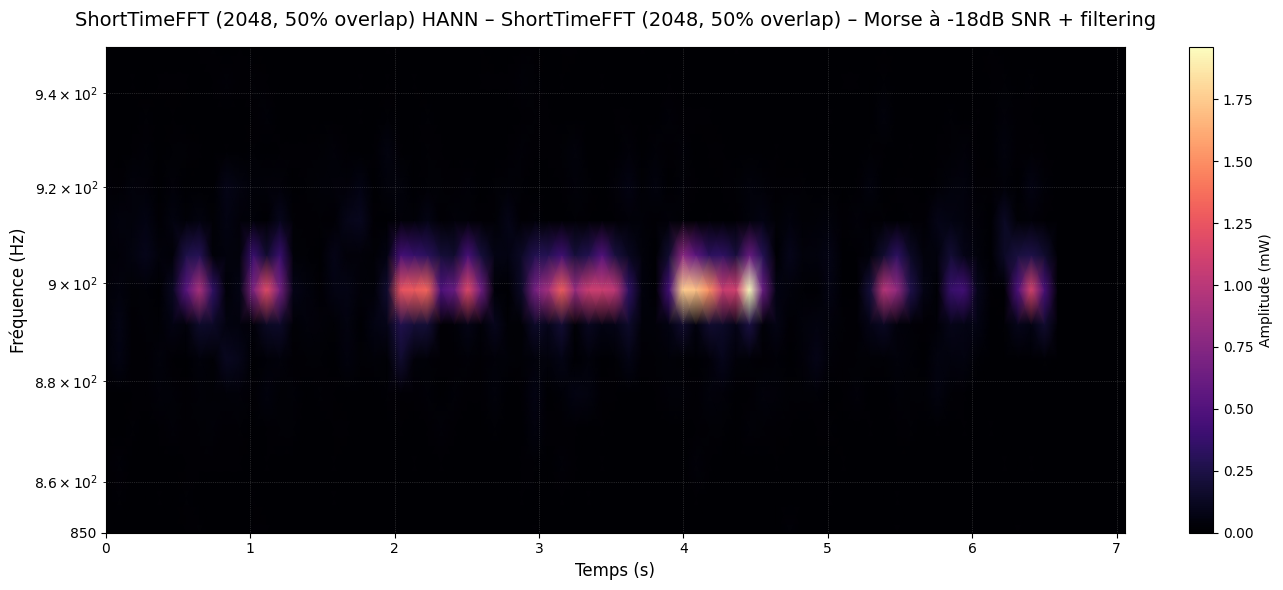

'done'

In [95]:
f0 = 900      # your tone
Q  = 30       # 10–30 typical for CW
fs = 11025
b, a = iirpeak(f0, Q, fs=fs)

# Apply the filter
filtered_signal = lfilter(b, a, morse_signal)

plot_stft_like_fcwt(
    filtered_signal,
    fs=fs,
    title="ShortTimeFFT (2048, 50% overlap) – Morse à " + str(snr_db) + "dB SNR + filtering",
    n_freqs_log = 15,
    fmin=850,
    fmax=950,
    nperseg = 2048
)
"done"

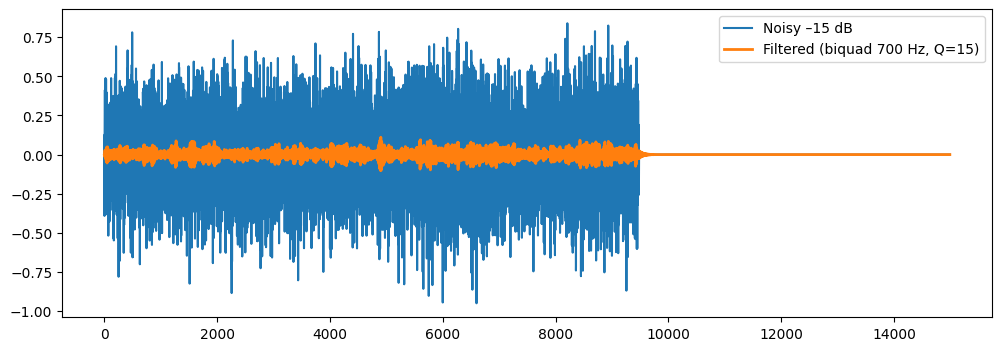

In [36]:
from scipy.signal import lfilter, iirpeak

# Generate noisy Morse
#morse_signal = generate_morse_signal(snr_db=-20, wpm=20)

# Apply perfect biquad bandpass at 700 Hz, Q=15
b, a = iirpeak(700, Q=15, fs=11025)
clean = lfilter(b, a, morse_signal)

# Plot before/after
plt.figure(figsize=(12,4))
plt.plot(morse_signal, label='Noisy –15 dB')
plt.plot(clean, label='Filtered (biquad 700 Hz, Q=15)', linewidth=2)
plt.legend()
plt.show()

In [5]:
import numpy as np
from scipy.signal import iirfilter, lfilter

def coherent_demodulate(
    signal: np.ndarray,
    fs: float,
    f_carrier: float,
    lowpass_cutoff: float = 30.0     # Coupure passe-bas sur I et Q (Hz)
) -> dict:
    """
    Démodulation synchrone avec filtrage passe-bas sur I et Q
    avant calcul de puissance et phase.
    
    Parameters
    ----------
    signal : np.ndarray
        Signal d'entrée
    fs : float
        Fréquence d'échantillonnage
    f_carrier : float
        Fréquence porteuse
    lowpass_cutoff : float, optional
        Coupure passe-bas sur I et Q (Hz)
    
    Returns
    -------
    dict with:
        - 'power'            : enveloppe brute (I² + Q²) après filtrage
        - 'power_filtered'   : enveloppe supplémentairement lissée
        - 'I'                : composante en phase filtrée
        - 'Q'                : composante en quadrature filtrée
        - 'phase'            : phase instantanée (atan2(Q, I))
        - 'phase_unwrapped'  : phase dépliée
        - 't'                : vecteur temps (s)
    """
    t = np.arange(len(signal)) / fs

    # === 1. Génération du LO complexe ===
    lo_cos = np.cos(2 * np.pi * f_carrier * t)   # I: cosine part
    lo_sin = np.sin(2 * np.pi * f_carrier * t)   # Q: sine part → sin(0) = 0 à t=0

    # === 2. Multiplication complexe ===
    I_raw = signal * lo_cos
    Q_raw = signal * lo_sin

    # === 3. Filtrage passe-bas sur I et Q ===
    b_lp, a_lp = iirfilter(2, lowpass_cutoff / (fs / 2), btype='low', ftype='butter')
    I_filtered = lfilter(b_lp, a_lp, I_raw)
    Q_filtered = lfilter(b_lp, a_lp, Q_raw)

    # === 4. Puissance et phase sur versions filtrées ===
    power_raw = I_filtered**2 + Q_filtered**2

    # Filtrage supplémentaire sur l'enveloppe (optionnel mais recommandé)
    power_filtered = lfilter(b_lp, a_lp, power_raw)

    # Normalisation
    if power_filtered.max() > 0:
        power_filtered = power_filtered / power_filtered.max()

    # Phase instantanée
    phase = np.atan2(Q_filtered, I_filtered)
    phase_unwrapped = np.unwrap(phase)

    return {
        'power': power_raw,
        'power_filtered': power_filtered,
        'I': I_filtered,
        'Q': Q_filtered,
        'phase': phase,
        'phase_unwrapped': phase_unwrapped,
        't': t,
        'fs': fs,
        'f_carrier': f_carrier
    }

In [12]:
import numpy as np
from scipy.signal import iirfilter, lfilter
from scipy.signal.windows import hann, hamming, flattop, blackman

# Dictionnaire des fenêtres supportées
WINDOW_FUNCTIONS = {
    'hann': hann,
    'hamming': hamming,
    'flattop': flattop,
    'blackman': blackman,
    # Ajoute-en d'autres si besoin
}

def coherent_demodulate_segmented(
    signal: np.ndarray,
    fs: float,
    f_carrier: float,
    segment_length: int,             # Longueur des segments (échantillons)
    overlap_factor: float = 0.5,     # Facteur de recouvrement (0–1)
    window: str = 'hann',            # Fenêtre ('hann', 'hamming', etc.)
    lowpass_cutoff: float = 100.0     # Coupure passe-bas (Hz)
) -> dict:
    """
    Démodulation synchrone segmentée avec recouvrement et fenêtrage.
    LO cohérent avec sine démarrant à t=0 (phase 0 globale).
    
    Parameters
    ----------
    signal : np.ndarray
        Signal d'entrée
    fs : float
        Fréquence d'échantillonnage
    f_carrier : float
        Fréquence porteuse
    segment_length : int
        Longueur des segments (échantillons)
    overlap_factor : float, optional
        Facteur de recouvrement (0–1)
    window : str, optional
        Fenêtre ('hann', 'hamming', etc.)
    lowpass_cutoff : float, optional
        Coupure passe-bas sur l'enveloppe
    
    Returns
    -------
    dict with:
        - 'power'            : enveloppe brute (I² + Q²)
        - 'power_filtered'   : enveloppe lissée
        - 'I'                : composante en phase (cosine)
        - 'Q'                : composante en quadrature (sine)
        - 'phase'            : phase instantanée (atan2(Q, I))
        - 't'                : vecteur temps (s)
    """
    if window not in WINDOW_FUNCTIONS:
        raise ValueError(f"Fenêtre non supportée : {window}. Choix : {list(WINDOW_FUNCTIONS.keys())}")

    hop = int(segment_length * (1 - overlap_factor))
    if hop <= 0:
        raise ValueError("overlap_factor trop élevé → hop <= 0")

    N = len(signal)
    t = np.arange(N) / fs
    
    # Initialisation des tableaux reconstruits (overlap-add)
    I_full = np.zeros(N)
    Q_full = np.zeros(N)
    S_full = np.zeros(N) # verif coherence
    weight_sum = np.zeros(N)  # Pour normalisation OLA

    # Fenêtre
    win_func = WINDOW_FUNCTIONS[window]
    win = win_func(segment_length, sym=False)

    # Boucle sur les segments
    start = 0
    while start + segment_length <= N:
        end = start + segment_length
        seg = signal[start:end]
        
        # Temps local pour LO (global → phase cohérente depuis t=0)
        t_seg = t[start:end]
        
        # LO complexe cohérent (sine commence à 0 à t=0 global)
        lo_cos = np.cos(2 * np.pi * f_carrier * t_seg)  # I: cosine part
        lo_sin = np.sin(2 * np.pi * f_carrier * t_seg)  # Q: sine part
        
        # Fenêtrage + multiplication
        I_seg = (seg * win) * lo_cos
        Q_seg = (seg * win) * lo_sin
        
        # Overlap-add
        I_full[start:end] += I_seg
        Q_full[start:end] += Q_seg
        S_full[start:end] += lo_sin
        weight_sum[start:end] += win
        
        start += hop

    # Normalisation OLA (évite artefacts)
    mask = weight_sum > 1e-10
    I_full[mask] /= weight_sum[mask]
    Q_full[mask] /= weight_sum[mask]

    # === NOUVEAU : Filtrage passe-bas lowpass_cutoff Hz sur I et Q ===
    # Butterworth 2ème ordre (biquad) – très efficace et stable
    b_lp, a_lp = iirfilter(2, lowpass_cutoff / (fs / 2), btype='low', ftype='butter')

    I_filtered = lfilter(b_lp, a_lp, I_full)
    Q_filtered = lfilter(b_lp, a_lp, Q_full)

    # === Calcul de puissance et phase sur les versions filtrées ===
    power_raw = I_filtered**2 + Q_filtered**2

    # Optionnel : un second filtrage léger sur l'enveloppe (pour un seuillage plus propre)
    power_filtered = lfilter(b_lp, a_lp, power_raw)

    # Normalisation de l'enveloppe
    if power_filtered.max() > 0:
        power_filtered = power_filtered / power_filtered.max()

    # Phase instantanée (unwrap recommandé pour visualisation continue)
    phase = np.atan2(Q_filtered, I_filtered)
    phase_unwrapped = np.unwrap(phase)  # Plus lisible pour plot

    return {
        'power': power_raw,                    # brut après filtrage I/Q
        'power_filtered': power_filtered,      # enveloppe finale lissée
        'I': I_filtered,                       # cosine part filtrée
        'Q': Q_filtered,                       # sine part filtrée
        'phase': phase,                        # phase avec sauts -π/π
        'phase_unwrapped': phase_unwrapped,    # phase continue
        't': t,
        'fs': fs,
        'f_carrier': f_carrier
    }


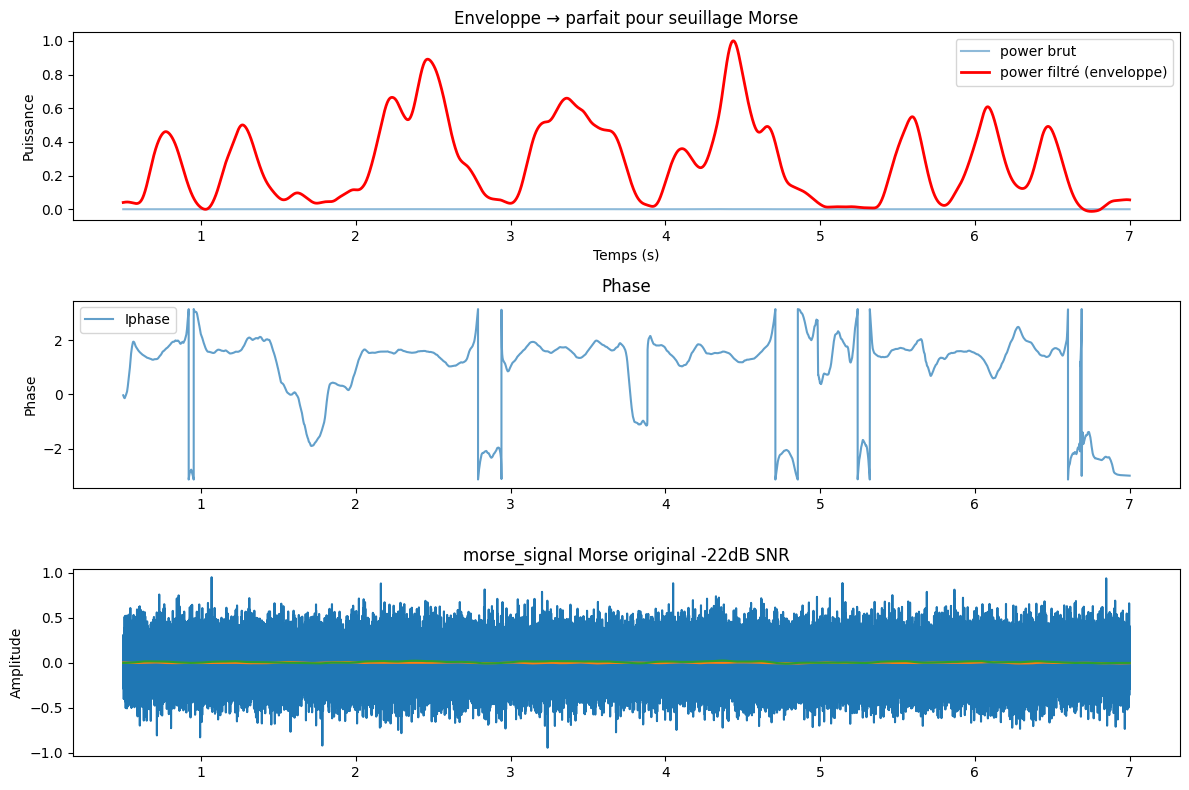

In [19]:
# Génère un signal très bruité
snr_db=-22
morse_signal = generate_morse_signal(text="ios", snr_db=snr_db, wpm=5)
fs = 11025
# Démodulation synchrone à fs Hz
result = coherent_demodulate_segmented(morse_signal, fs=fs, f_carrier=900, segment_length = 2500, overlap_factor = 0.8, 
                                       window = 'flattop', lowpass_cutoff=3)
#result = coherent_demodulate(morse_signal, fs=11025, f_carrier=900, lowpass_cutoff=3)

# Extraction des résultats
power = result['power_filtered']   # ← c’est ça que tu veux pour décoder !
I = result['I']
Q = result['Q']
t = result['t']
phase = result['phase']
#sin_co = result['sin_co']

# === Affichage ===
#import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
start_sample = int(0.498 * fs)
end_sample = int(7 * fs)

plt.subplot(3,1,3)
plt.plot(t[start_sample:end_sample],morse_signal[start_sample:end_sample], label='morse')
#plt.plot(t[start_sample:end_sample],sin_co[start_sample:end_sample], label='ref')
plt.plot(t[start_sample:end_sample],I[start_sample:end_sample], label='I')
plt.plot(t[start_sample:end_sample],Q[start_sample:end_sample], label='Q')
plt.title(f'morse_signal Morse original {snr_db}dB SNR')
plt.ylabel('Amplitude')

plt.subplot(3,1,2)
plt.plot(t[start_sample:end_sample], phase[start_sample:end_sample], label='Iphase', alpha=0.7)
plt.legend()
plt.title('Phase')
plt.ylabel('Phase')

plt.subplot(3,1,1)
plt.plot(t[start_sample:end_sample], result['power'][start_sample:end_sample], label='power brut', alpha=0.5)
plt.plot(t[start_sample:end_sample], power[start_sample:end_sample], 'red', linewidth=2, label='power filtré (enveloppe)')
plt.title('Enveloppe → parfait pour seuillage Morse')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance')
plt.legend()

plt.tight_layout()
plt.show()

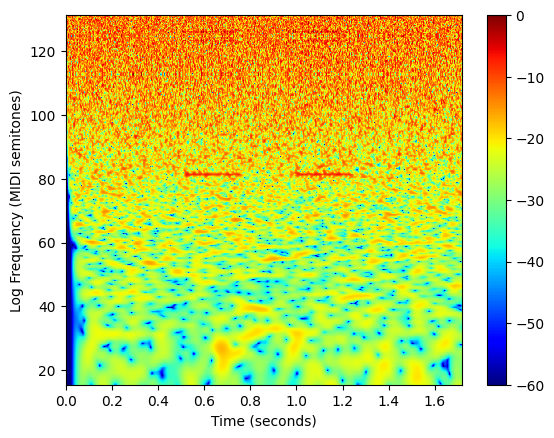

In [293]:
import numpy as np
import pygabor.spectrogram
from importlib import reload
reload(pygabor.spectrogram)
# Generate a synthetic test signal with a harmonic spectrum
harmonic, samplfreq = pygabor.spectrogram.harmonictestsignal()
# Compute spectrogram based on the time-causal analogue of the Gabor transform for distribution parameter c = sqrt(2)
morse_signal=generate_morse_signal(text="i", snr_db=-15 , wpm=5)
spectr1 = pygabor.spectrogram.auditory_spectrogram(morse_signal, 11025, 'timecausgabor-csqrt2')
pygabor.spectrogram.showlog(spectr1)

In [65]:
for k_ in range(1024,morse_signal.size,1024):
    print(k_)

1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432


In [148]:
from collections.abc import Generator, Callable
from typing import get_args, Literal
PAD_TYPE = Literal['zeros', 'edge', 'even', 'odd']
from functools import partial, cached_property
from scipy.signal._signaltools import detrend
def my_detrend(self, x: np.ndarray,
                     detr: Callable[[np.ndarray], np.ndarray] | Literal['linear', 'constant'] | None,  # noqa: E501
                     p0: int | None = None, p1: int | None = None, *,
                     k_offset: int = 0, padding: PAD_TYPE = 'zeros',
                     axis: int = -1) \
            -> np.ndarray:
        """Calculate short-time Fourier transform with a trend being subtracted from
        each segment beforehand.

        When the parameter `detr` is ``None``, this method's behavior is identical to
        the `~ShortTimeFFT.stft` method. Note that due to the detrending, the original
        signal cannot be reconstructed by the `~ShortTimeFFT.istft`.

        Parameters
        ----------
        x : np.ndarray
            The input signal as real or complex valued array. For complex values, the
            property `fft_mode` must be set to 'twosided' or 'centered'.
        detr : 'linear' |  'constant' |  Callable[[np.ndarray], np.ndarray] | None
            If 'constant', the mean is subtracted, if set to "linear", the linear
            trend is removed from each segment. This is achieved by calling
            `~scipy.signal.detrend`. If `detr` is a function with one parameter, `detr`
            is applied to each segment.
        p0 : int | None
            The first element of the range of slices to calculate. If ``None``
            then it is set to :attr:`p_min`, which is the smallest possible
            slice.
        p1 : int | None
            The end of the array. If ``None`` then `p_max(n)` is used.
        k_offset : int
            Index of first sample (t = 0) in `x`.
        padding : 'zeros' | 'edge' | 'even' | 'odd'
            Kind of values which are added, when the sliding window sticks out
            on either the lower or upper end of the input `x`. Zeros are added
            if the default 'zeros' is set. For 'edge' either the first or the
            last value of `x` is used. 'even' pads by reflecting the
            signal on the first or last sample and 'odd' additionally
            multiplies it with -1.
        axis: int
            The axis of `x` over which to compute the STFT.
            If not given, the last axis is used.

        Returns
        -------
        S : np.ndarray
            A complex array is returned with the dimension always being larger
            by one than of `x`. The last axis always represents the time slices
            of the STFT. `axis` defines the frequency axis (default second to
            last). E.g., for a one-dimensional `x`, a complex 2d array is
            returned, with axis 0 representing frequency and axis 1 the time
            slices.

        See Also
        --------
        invertible: Check if STFT is invertible.
        :meth:`~ShortTimeFFT.istft`: Inverse short-time Fourier transform.
        :meth:`~ShortTimeFFT.stft`: Short-time Fourier transform
                                   (without detrending).
        :class:`scipy.signal.ShortTimeFFT`: Class this method belongs to.
        """
        if self.onesided_fft and np.iscomplexobj(x):
            raise ValueError(f"Complex-valued `x` not allowed for {self.fft_mode=}'! "
                             "Set property `fft_mode` to 'twosided' or 'centered'.")
        if isinstance(detr, str):
            detr = partial(detrend, type=detr)
        elif not (detr is None or callable(detr)):
            raise ValueError(f"Parameter {detr=} is not a str, function or " +
                             "None!")
        n = x.shape[axis]
        if not (n >= (m2p := self.m_num-self.m_num_mid)):
            e_str = f'{len(x)=}' if x.ndim == 1 else f'of {axis=} of {x.shape}'
            raise ValueError(f"{e_str} must be >= ceil(m_num/2) = {m2p}!")

        if x.ndim > 1:  # motivated by the NumPy broadcasting mechanisms:
            x = np.moveaxis(x, axis, -1)
        # determine slice index range:
        p0, p1 = self.p_range(n, p0, p1)
        S_shape_1d = (self.win.size, p1 - p0)
        S_shape = x.shape[:-1] + S_shape_1d if x.ndim > 1 else S_shape_1d
        S = np.zeros(S_shape, dtype=complex)
        T = np.zeros(p1 - p0)
        for p_, x_ in enumerate(self._x_slices(x, k_offset, p0, p1, padding)):
            if detr is not None:
                x_ = detr(x_)
            S[..., :, p_] = (x_ * self.win.conj())
       #    T[p_] = 
        # if x.ndim > 1:
        #     return np.moveaxis(S, -2, axis if axis >= 0 else axis-1)
        return np.moveaxis(S,-1,-2)
        #return S

def coherent_segments(
    signal_to_process: np.ndarray,
    fs: float = 11025.0,
    fmin: float = 150.0,
    fmax: float = 1100.0,
    n_freqs_log: int = 400,
    hop: int | None = None,
    nperseg: int | None = None,
    title: str = "STFT (ShortTimeFFT) – équivalent fCWT",
    cmap: str = 'magma',
    vmin: float | None = None,
    vmax: float | None = None,
    figsize=(14, 6)
):
    """
    Scalogramme avec ShortTimeFFT – rétro-compatible SciPy 1.4+
    """
    fmin = max(fmin, 1e-6)   # Sécurité log

    # === 1. Choix intelligent de nperseg et hop ===
    if nperseg is None:
        desired_bins = 40
        nperseg = int(fs * desired_bins / (fmax - fmin))
        nperseg = max(nperseg, 512)
        nperseg = 2 ** int(np.log2(nperseg) + 0.5)   # Puissance de 2
        print ("FFT width: " + str(nperseg))

    if hop is None:
        hop = nperseg // 2                            # 50% overlap

    window = hann(nperseg, sym=False)  # Fonctionne maintenant !

    # === 2. ShortTimeFFT ===
    SFT = ShortTimeFFT(window, hop, fs, fft_mode='onesided')
    return my_detrend(SFT,signal_to_process,'linear')

In [22]:
import numpy as np
from scipy.signal import iirfilter, lfilter

def coherent_demodulate_4x_hardware(
    signal_resampled: np.ndarray,
    f_carrier: float,
    lowpass_cutoff: float = 30.0
) -> dict:
    """
    Démodulation cohérente pour signal rééchantillonné à fs = 4 * f_carrier.
    Gestion robuste des longueurs non multiples de 4.
    """
    fs = 4 * f_carrier
    N = len(signal_resampled)
    
    if abs(fs - 4 * f_carrier) > 1e-6 * fs:
        raise ValueError(f"fs doit être exactement 4 * f_carrier ({4*f_carrier} Hz)")

    # === 1. Calcul du nombre maximum d'échantillons I/Q valides ===
    num_full_cycles = N // 4
    total_iq_samples = num_full_cycles * 2  # 2 par cycle (I et Q)

    # Indices valides
    idx_I_pos = np.arange(0, 4*num_full_cycles, 4)        # phase 0°   → +s
    idx_I_neg = np.arange(2, 4*num_full_cycles, 4)        # phase 180° → -s
    idx_Q_pos = np.arange(1, 4*num_full_cycles, 4)        # phase 90°  → +s
    idx_Q_neg = np.arange(3, 4*num_full_cycles, 4)        # phase 270° → -s

    # === 2. Construction de I et Q ===
    I_raw = np.empty(total_iq_samples)
    I_raw[0::2] =  signal_resampled[idx_I_pos]   # +s à 0°
    I_raw[1::2] = -signal_resampled[idx_I_neg]   # -s à 180° → on inverse

    Q_raw = np.empty(total_iq_samples)
    Q_raw[0::2] =  signal_resampled[idx_Q_pos]   # +s à 90°
    Q_raw[1::2] = -signal_resampled[idx_Q_neg]   # -s à 270° → on inverse

    # === 3. Temps et fréquence après décimation ===
    fs_decimated = f_carrier
    t_decimated = np.arange(total_iq_samples) / fs_decimated

    # === 4. Filtrage passe-bas ===
    b_lp, a_lp = iirfilter(2, lowpass_cutoff / (fs_decimated / 2),
                          btype='low', ftype='butter')
    I_filtered = lfilter(b_lp, a_lp, I_raw)
    Q_filtered = lfilter(b_lp, a_lp, Q_raw)

    # === 5. Puissance et phase ===
    power_raw = I_filtered**2 + Q_filtered**2
    power_filtered = lfilter(b_lp, a_lp, power_raw)

    if power_filtered.max() > 0:
        power_filtered /= power_filtered.max()

    phase = np.atan2(Q_filtered, I_filtered)
    phase_unwrapped = np.unwrap(phase)

    return {
        'power': power_raw,
        'power_filtered': power_filtered,
        'I': I_filtered,
        'Q': Q_filtered,
        'phase': phase,
        'phase_unwrapped': phase_unwrapped,
        't': t_decimated,
        'fs_original': fs,
        'fs_decimated': fs_decimated,
        'f_carrier': f_carrier,
        'dropped_samples': N - 4*num_full_cycles  # Info utile
    }

In [177]:
import numpy as np
from scipy.signal import resample, iirfilter, lfilter, butter, bessel

def coherent_demodulate_4x_hardware_with_prefilter(
    signal: np.ndarray,
    fs_original: float,
    f_carrier: float,
    lowpass_cutoff: float = 30.0     # Coupure finale sur I/Q après décimation (Hz)
) -> dict:
    """
    Démodulation cohérente 4×fc avec pré-filtrage anti-aliasing à 2*f_carrier.
    
    Étapes :
    1. Filtre passe-bas à 2*f_carrier (anti-aliasing) ou à f_carrier using bessel functions
    2. Rééchantillonnage à fs_new = 4 * f_carrier
    3. Extraction directe I/Q par sélection (pas de multiplication trig)
    4. Filtrage final sur I/Q
    
    Parameters
    ----------
    signal : np.ndarray
        Signal original à fs_original
    fs_original : float
        Fréquence d'échantillonnage originale
    f_carrier : float
        Fréquence porteuse
    lowpass_cutoff : float
        Coupure passe-bas finale sur I et Q (Hz)
    
    Returns
    -------
    dict avec power_filtered, I, Q, phase, etc.
    """
    # === 1. Pré-filtrage anti-aliasing à 2 * f_carrier ===
    cutoff = 2*f_carrier
    if cutoff >= fs_original / 2:
        raise ValueError(f"2*f_carrier ({cutoff} Hz) >= Nyquist ({fs_original/2} Hz). Impossible.")

    # Butterworth 4ème ordre (8 dB/octave → bonne atténuation)
    b_prefilt, a_prefilt = butter(4, cutoff / (fs_original / 2), btype='low')
    signal_filtered = lfilter(b_prefilt, a_prefilt, signal)

    
    # Bessel 4ème ordre à f_carrier
    b_bessel, a_bessel = butter(4, f_carrier / (fs_original / 2), btype='low')
    signal_filtered = lfilter(b_bessel, a_bessel, signal_filtered)

    # === 2. Rééchantillonnage à fs_new = 4 * f_carrier ===
    fs_new = 4 * f_carrier
    num_samples_new = int(round(len(signal_filtered) * fs_new / fs_original))
    signal_resampled = resample(signal_filtered, num_samples_new)

    N = len(signal_resampled)

    # === 3. Extraction directe I/Q (gestion robuste des longueurs) ===
    num_full_cycles = N // 4
    total_iq_samples = num_full_cycles * 2

    idx_I_pos = np.arange(0, 4*num_full_cycles, 4)      # phase 0°
    idx_I_neg = np.arange(2, 4*num_full_cycles, 4)      # phase 180°
    idx_Q_pos = np.arange(1, 4*num_full_cycles, 4)      # phase 90°
    idx_Q_neg = np.arange(3, 4*num_full_cycles, 4)      # phase 270°

    I_raw = np.empty(total_iq_samples)
    I_raw[0::2] =  signal_resampled[idx_I_pos]
    I_raw[1::2] = -signal_resampled[idx_I_neg]

    Q_raw = np.empty(total_iq_samples)
    Q_raw[0::2] =  signal_resampled[idx_Q_pos]
    Q_raw[1::2] = -signal_resampled[idx_Q_neg]

    # === 4. Temps et fs après décimation ===
    fs_decimated = f_carrier
    t_decimated = np.arange(total_iq_samples) / fs_decimated

    # === 5. Filtrage final sur I et Q ===
    b_lp, a_lp = iirfilter(2, lowpass_cutoff / (fs_decimated / 2),
                          btype='low', ftype='butter')
    I_filtered = lfilter(b_lp, a_lp, I_raw)
    Q_filtered = lfilter(b_lp, a_lp, Q_raw)

    # === 6. Puissance et phase ===
    power_raw = I_filtered**2 + Q_filtered**2
    power_filtered = lfilter(b_lp, a_lp, power_raw)

    if power_filtered.max() > 0:
        power_filtered /= power_filtered.max()

    phase = np.atan2(Q_filtered, I_filtered)
    phase_unwrapped = np.unwrap(phase)

    return {
        'power': power_raw,
        'power_filtered': power_filtered,
        'I': I_filtered,
        'Q': Q_filtered,
        'phase': phase,
        'phase_unwrapped': phase_unwrapped,
        't': t_decimated,
        'fs_original': fs_original,
        'fs_resampled': fs_new,
        'fs_decimated': fs_decimated,
        'f_carrier': f_carrier,
        'dropped_samples': N - 4*num_full_cycles,
        'prefilter_cutoff': cutoff
    }

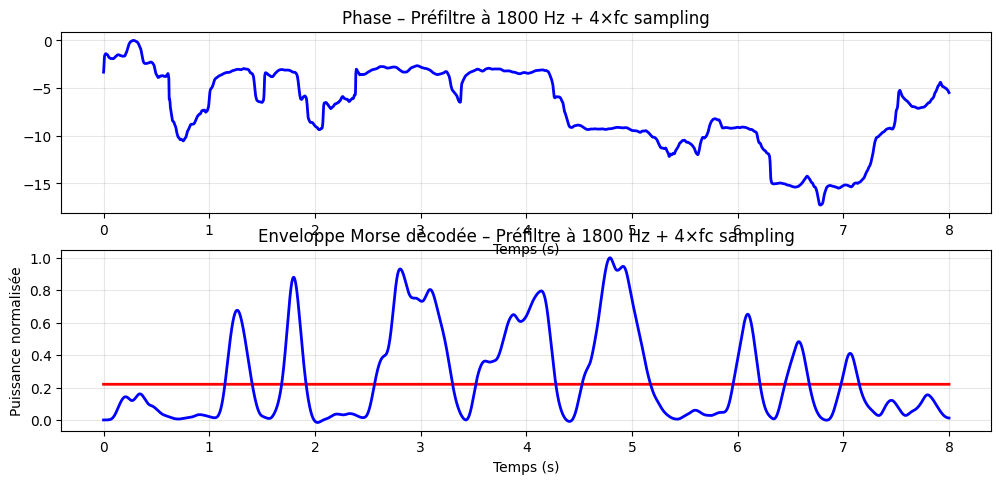

In [205]:
# Exemple complet
fs_orig = 11025
f_carrier = 900
snr_db = -20


signal = generate_morse_signal(text="ios", snr_db=snr_db , wpm=10, carrier_freq=900)
signal = signal * 0.1

result = coherent_demodulate_4x_hardware_with_prefilter(
    signal,
    fs_original=fs_orig,
    f_carrier=f_carrier,
    lowpass_cutoff=3
)

# Visualisation
import matplotlib.pyplot as plt
end_sample = min(int(14 * f_carrier),result['t'].size)
plt.figure(figsize=(12,8))
plt.subplot(3,1,2)
plt.plot(result['t'][:end_sample], np.full(end_sample,0.22), 'red', linewidth=2)
plt.plot(result['t'][:end_sample], result['power_filtered'][:end_sample], 'blue', linewidth=2)
plt.title(f'Enveloppe Morse décodée – Préfiltre à {2*f_carrier} Hz + 4×fc sampling')
plt.xlabel('Temps (s)')
plt.grid(True, alpha=0.3)
plt.ylabel('Puissance normalisée')

plt.subplot(3,1,1)
plt.plot(result['t'][:end_sample], result['phase_unwrapped'][:end_sample]-3, 'blue', linewidth=2)
plt.title(f'Phase – Préfiltre à {2*f_carrier} Hz + 4×fc sampling')
plt.xlabel('Temps (s)')
plt.grid(True, alpha=0.3)
plt.show()

# Plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 8))

# start_sample = int(0.498 * fs_original)
# end_sample = int(7 * fs_original)

# start_resample = int(start_sample*fs_resampled/fs_original)
# end_resample = int(end_sample*fs_resampled/fs_original)

# plt.subplot(3,1,2)
# plt.plot(t_orig[start_sample:end_sample],signal_original[start_sample:end_sample])
# plt.title(f'morse_signal Morse original {snr_db} dB SNR')
# plt.ylabel('Amplitude')

# plt.subplot(3,1,1)
# plt.plot(result['t'][start_resample:end_resample], result['power_filtered'][start_resample:end_resample])
# plt.title("Enveloppe Morse extraite – Démodulation hardware 4×fc")
# plt.show()

In [162]:
fs_original = 11025
f_carrier = 900
fs_resampled = f_carrier * 4
snr_db = -20

# Rééchantillonnage (simule le hardware)
signal_original = generate_morse_signal(text="ios", snr_db=snr_db , wpm=5)
t_orig = np.arange(len(signal_original)) / fs_original
# === 4. Filtrage passe-bas ===
b_lp, a_lp = iirfilter(2, lowpass_cutoff / (fs_original / 2),
                      btype='low', ftype='butter')
I_filtered = lfilter(b_lp, a_lp, I_raw)

signal_resampled = np.interp(
    np.arange(0, len(signal_original), fs_original/fs_resampled),
    np.arange(len(signal_original)),
    signal_original
)

result = coherent_demodulate_4x_hardware(signal_resampled, f_carrier=900, lowpass_cutoff=3)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

start_sample = int(0.498 * fs_original)
end_sample = int(7 * fs_original)

start_resample = int(start_sample*fs_resampled/fs_original)
end_resample = int(end_sample*fs_resampled/fs_original)

plt.subplot(3,1,2)
plt.plot(t_orig[start_sample:end_sample],signal_original[start_sample:end_sample])
plt.title(f'morse_signal Morse original {snr_db} dB SNR')
plt.ylabel('Amplitude')

plt.subplot(3,1,1)
plt.plot(result['t'][start_resample:end_resample], result['power_filtered'][start_resample:end_resample])
plt.title("Enveloppe Morse extraite – Démodulation hardware 4×fc")
plt.show()

NameError: name 'lowpass_cutoff' is not defined

In [210]:
morse_signal.size/1024

18.517578125

In [213]:
np.arange(len(P))*morse_signal.size/fs/len(P)

array([0.        , 0.04410024, 0.08820048, 0.13230072, 0.17640095,
       0.22050119, 0.26460143, 0.30870167, 0.35280191, 0.39690215,
       0.44100238, 0.48510262, 0.52920286, 0.5733031 , 0.61740334,
       0.66150358, 0.70560381, 0.74970405, 0.79380429, 0.83790453,
       0.88200477, 0.92610501, 0.97020524, 1.01430548, 1.05840572,
       1.10250596, 1.1466062 , 1.19070644, 1.23480667, 1.27890691,
       1.32300715, 1.36710739, 1.41120763, 1.45530787, 1.49940811,
       1.54350834, 1.58760858, 1.63170882, 1.67580906])

In [ ]:
threshold = 0.15
binary = (power > threshold).astype(int)

# Détection des durées
import numpy as np
diff = np.diff(binary, prepend=0)
starts = np.where(diff == 1)[0] / fs
ends   = np.where(diff == -1)[0] / fs

morse = ""
for s, e in zip(starts, ends):
    dur = (e - s) * 1000  # ms
    if 40 < dur < 120:
        morse += "."
    elif 120 < dur < 400:
        morse += "-"
    # espaces gérés par gaps

print("Morse décodé :", morse)

In [154]:
SS.shape[0]

20

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
